# Kategorisierung der Ohrbilder

Mit diesem Jupyter-Skript werden alle notwendigen Funktionen zur Umsetzung und Auswertung der Kategorisierung von Ohrbildern zusammengefasst.  
Das Jupyter-Skript bezieht sich auf die Masterarbeit: "Verwendung des menschlichen Ohrs zur Personenauthentifizierung an IT-Systemen mittels CNNs"

## Bibliotheken importieren

Zunächst werden alle notwendigen Bibliothken importiert


In [1]:
## Import Libearies ##
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os

# Import TORCHVISION with popular datasets, model architectures, 
# and common image transformations for computer vision
from torchvision import transforms
import torchvision
import torchvision.utils
import torchvision.models as models
import torchsummary

# Import Debugging method for set_trace
from IPython.core.debugger import set_trace
import logging

# Import Time Features
import datetime
import time

# Import TORCH for Data-Structures for multi-dimensional tensors 
# and mathematical operations
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torch_utils
#import python_utils
#import utils
#from ignite.metrics import EpochMetric 

# Import Winsound to play a *.wav-File
# and Counter for counting numbers in an array
import winsound
from collections import Counter

# Import Random Libery
import random
from random import shuffle

# Import IPYWIDGET for interactive HTML widgets for Jupyter notebooks
import ipywidgets as wg
from IPython.display import display

# Import PYTORCH LIGHTNING as a PyTorch research framework
from pytorch_lightning.metrics.classification import ROC, F1 
from pytorch_lightning.metrics.functional.classification import multiclass_auroc
#from pytorch_lightning.metrics import Precision, functional, Recall
from pytorch_lightning.metrics.functional.classification import auc, auroc, multiclass_roc, f1_score
from  pytorch_lightning.metrics.utils import to_onehot

from pytorch_lightning.metrics.functional import roc
#from pytorch_lightning.metrics.functional import precision_recall_curve
from pytorch_lightning.metrics import Accuracy
from pytorch_lightning.metrics.classification import AveragePrecision


# Import ScikitLearn for AUC-Score
#from sklearn.metrics import roc_auc_score

## Festlegung: Prozessor oder Graphikkarte

Falls NVIDIA-Graphikkarte und CUDA vorhanden ist, dann wird die GPU für Berechnungen genutzt

In [2]:
# Read Device: Choose CUDA, if NVIDIA GPU is avaiabel
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Voreinstellungen - Hilfsfunktionen

* **secs_to_HMS():** Berechnte Sekunden in HH:MM:SS um
* **WaitTime_Finished():** Gibt eine Audio-Datei aus, wenn Training und Testen beendet ist

In [3]:
## Convert Seconds to Hours, Minutes and Seconds ##
def secs_to_HMS(secs):
    if (secs < 3600):
        return datetime.datetime.fromtimestamp(secs).strftime('%M:%S'), "[MM:SS]"
    else:
        return datetime.datetime.fromtimestamp(secs).strftime('%H:%M:%S'), "[HH:MM:SS]"

## Acustic Sound if Model-Trainings finished ##
def WaitTime_Finished():
    for i in range(2):
        files=os.listdir("Sound/")
        file=random.choice(files)
        winsound.PlaySound("Sound/"+str(file), winsound.SND_FILENAME)
        time.sleep(2)

## Funtionen um Datensätze festzulegen, einzulesen und anzuzeigen

* **ChooseDir():**             return: Datensatz-Verzeichnis und Datensatz-String  
* **Show_Dataset_Picture():**  Zeigt erstes Bild eines Datensatzes
* **Create_Dataset():**        Erzeugt Datensatz-Arrays für Training und Testen
* **Create_Dataset():**        Erzeugt erweiterte Datensatz-Arrays für Training und Testen


Hinweis: Nur 20 Probanden des AMI-Datensatzes sind in den Datenätzen vorhanden. Mehr konnte bei Git nicht hochgeladen werden.

In [4]:
## Indirect Path for Linux and Windows## 
def ChooseDir(datadir):
    if(datadir == 'CP'):
        return "Datensaetze/CP", "CP"
    if(datadir == 'AMI'):
        return "Datensaetze/AMI", "AMI"
    if(datadir == 'AWE'):
        return "Datensaetze/AWE", "AWE"
    if(datadir == 'EarVN'):
        return "Datensaetze/EarVN_1_0", "EarVN_1_0"
    if(datadir == 'UERC'):
        return "Datensaetze/UERC", "UERC"

## Show first Picture of choosen Dataset    
def Show_Dataset_Picture(datadir, categories):
    for category in categories:
        path = os.path.join(datadir, category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
            plt.show()
            break
        break   
        

## Create normal Dataset 
def Create_Dataset(datadir, categories):
    ## Transformer for Images ##
    ## For PyTorch Models use: mean = [0.4318, 0.4660, 0.5889], std = [0.1752, 0.1893, 0.2096]
    transformer = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.4318, 0.4660, 0.5889), (0.1752, 0.1893, 0.2096))
        ])

    ## Define Size of Images; 
    ## For PyTorch Models use: IMG_Size = 224 
    IMG_SIZE = 224

    ## Create normal dataset for all Databases and Categories 
    for category in categories:
        ## Get path of each Category
        path = os.path.join(datadir, category)
        
        ## Create class numbers for each Category
        class_num = categories.index(category)
        
        ## Calculate train_share for Train- and Testdataset
        count_train_share = (len(os.listdir(path)))*train_share
        counter = 1
        
        ## Get all Images of current Category
        os_listdir = os.listdir(path)
        ## Sort the Pictures-Path of each category randomly
        random.shuffle(os_listdir)

        for img in os_listdir:
            try:
                ## Read, Resize, and Transform image
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                img_array = transformer(img_array)
                
                ## Split Images to Train- and Test-Dataset-Array
                if(counter <= count_train_share):
                    dataset_train.append([img_array, class_num])
                    counter += 1
                else:
                    dataset_test.append([img_array, class_num])
            except Exception as e:
                 pass
    
    ## Rondomly sortig dataset_train and dataset_test Arrays
    random.shuffle(dataset_train)
    random.shuffle(dataset_test)



## Create expand Dataset    
def Create_Dataset_Expand(datadir, categories):
    ## Transformer for Images: ToTensor() ad Normalize 
    ## For PyTorch Models: to Normalize images use: mean = [0.4318, 0.4660, 0.5889], std = [0.1752, 0.1893, 0.2096]
    transformer = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.4318, 0.4660, 0.5889), (0.1752, 0.1893, 0.2096)),
        ])

    ## Define Size of Images; 
    ## For PyTorch Models use: IMG_Size = 224 
    IMG_SIZE = 224

    ## Create expand  dataset for all Databases (except for: EarVN1.0 Database)
    for i in range(4):
        for category in categories:
            ## Get path of each Category
            path = os.path.join(datadir, category)
            
            ## Create class numbers for each Category
            class_num = categories.index(category)
            
            ## Calculate train_share for Train- and Testdataset
            count_train_share = round((len(os.listdir(path)))*train_share)
            counter = 1
            
            ## Get all Images of current Category
            os_listdir = os.listdir(path)
            
            ## Sort the Pictures-Path of each category randomly
            random.shuffle(os_listdir)
            
            for img in os_listdir:
                    ## Read, Resize, and Transform image
                    img_array = cv2.imread(os.path.join(path, img))
                    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                     
                    ## Rotate Image
                    rows,cols,ch = img_array.shape
                    rotate_numbers = [0, 90, 180, 270]
                    rotate_number = rotate_numbers[i]
                    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotate_number,1) ## cols-1 and rows-1 are the coordinate limits.
                    img_array = cv2.warpAffine(img_array,M,(cols,rows))
                    
                    ## Transform the img-Array
                    img_array = transformer(img_array)
                    
                    ## Split Images to Train- and Test-Dataset-Array
                    if(counter <= count_train_share):
                        dataset_train.append([img_array, class_num])
                        counter += 1
                    else:
                        dataset_test.append([img_array, class_num])
    
    ## Randomly sortig dataset_train and dataset_test Arrays
    random.shuffle(dataset_train)
    random.shuffle(dataset_test)

## Funktionen um vortrainiertes Netzwerk festzulegen

* **Network_Choice():** Gibt Netzwerk und Netzwerk-String zurück

In [5]:
## All pretrained Networks from PyTorch ##

network_name = 'nix'

# Function to choose network
# return: pretrained Network, Name of Network
def Network_Choice(netw):    
    if(netw == 'vgg11'):
        return models.vgg11(pretrained=True).to(DEVICE), "VGG11"
    if(netw == 'vgg11bn'):
        return models.vgg11_bn(pretrained=True).to(DEVICE), "VGG11bn"
    if(netw == 'resnet18'):
        return models.resnet18(pretrained=True).to(DEVICE), "ResNet18"
    if(netw == 'resnet34'):
        return models.resnet34(pretrained=True).to(DEVICE), "ResNet34"
    if(netw == 'alexnet'):
        return models.alexnet(pretrained=True).to(DEVICE), "AlexNet"
    if(netw == 'squeezenet1_0'):
        return models.squeezenet1_0(pretrained=True).to(DEVICE), "SqueezeNet-1-0"  
    if(netw == 'GoogLeNet'):
        return models.googlenet(pretrained=True).to(DEVICE), "GoogLeNet" 
    if(netw == 'shufflenet_v2_x0_5'):
        return models.shufflenet_v2_x0_5(pretrained=True).to(DEVICE), "Shufflenet-v2-x0_5"  
    if(netw == 'resnext101_32x8d'):
        return models.resnext101_32x8d(pretrained=True).to(DEVICE), "Resnext101-32x8d"

## Funktionen für die Ausgabe von Ohrbildern und dazugehöriger Labels

* **imshow():** Zeigt Bild
* **matplotlib_imshow():** Ordnet 4 Ohrbilder mit dazugehörigem Label an

In [6]:
# functions to show an image

# Inverse the transformation of the images
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.1752, 1/0.1893, 1/0.2096 ]),
                                transforms.Normalize(mean = [ -0.4318, -0.4660, -0.5889 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

def imshow(img):
    img = invTrans(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    #set_trace()
    img = invTrans(img)      # unnormalize
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    #set_trace()
    if one_channel:
        plt.imshow(npimg)        
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

## Klasse zur Berechnung von Top-1 und Top-5 Accuracy

In [7]:
## Class of Top-1 and Top-5 Accuracy
class AvgrageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

## Accuracy jeder Kategorie in Log-File (TXT-File)

In [8]:
## Write Accuracy of every Categorie to Log-Files (TXT-File) ##
def Write_Each_Categorie_Acc_To_Editor(database, net, acc_per_categorie):
    logfile_path = './Log_Files/' + database + '/' + str(current_time) + '_' + net + '.txt'
    datei = open(logfile_path, 'a')
    datei.write(acc_per_categorie)
    datei.close()

## Konfiguration

Auswahl von: 
* Datensatz
* Netzwerk
* Normaler/Erweiterter Datensatz
* Trainshare
* Batch Size Train
* Batch Size Test
* Learning Rate
* Momentum

Hinweis: Konfiguration ausführen, Auswahl festlegen und weiter zum nächsten Abschnitt

In [9]:
## Choose Dataset
datadir_choose = wg.Dropdown(
     options=['CP', 'AMI', 'AWE', 'EarVN', 'UERC'],
     value='AMI',
     description='Dataset:',
     disabled=False,
     button_style=''
)

## Choose Network
network_string_choose = wg.Dropdown(
     options=['vgg11','vgg11bn','resnet18','resnet34','alexnet','squeezenet1_0','GoogLeNet','shufflenet_v2_x0_5','resnext101_32x8d', 'siamese'],
     value='vgg11',
     description='Network:',
     disabled=False,
     button_style=''
)

## Choose Normal or expand network
normal_expand_string_choose = wg.Dropdown(
     options=['Normal_Network', 'Expand_Network'],
     value='Normal_Network',
     description='Normal/Exp:',
     disabled=False,
     button_style=''
)

## Choose Trainshare
trainshare_choose = wg.BoundedFloatText(
     value=0.8,
     min=0,
     max=1,
     step=0.1,
     description='Trainshare:',
     disabled=False
)

## Choose Batch_Size for Training
batch_train = wg.BoundedIntText(
     value=4,
     min=1,
     max=100,
     step=1,
     description='Batch_Train:',
     disabled=False
)

## Choose Batch_Size for Testing
batch_test = wg.BoundedIntText(
     value=4,
     min=1,
     max=100,
     step=1,
     description='Batch_Test:',
     disabled=False
)

## Choose Learning-Rate
learning_rate_choose = wg.BoundedFloatText(
     value=0.001,
     min=0,
     max=1,
     step=0.0001,
     description='Learning_Rate',
     disabled=False
)

## Choose 
momentum_choose = wg.BoundedFloatText(
     value=0.8,
     min=0,
     max=1,
     step=0.1,
     description='Momentum: ',
     disabled=False
)


display(datadir_choose, network_string_choose, normal_expand_string_choose, trainshare_choose, batch_train, batch_test, learning_rate_choose, momentum_choose)

Dropdown(description='Dataset:', index=1, options=('CP', 'AMI', 'AWE', 'EarVN', 'UERC'), value='AMI')

Dropdown(description='Network:', options=('vgg11', 'vgg11bn', 'resnet18', 'resnet34', 'alexnet', 'squeezenet1_…

Dropdown(description='Normal/Exp:', options=('Normal_Network', 'Expand_Network'), value='Normal_Network')

BoundedFloatText(value=0.8, description='Trainshare:', max=1.0, step=0.1)

BoundedIntText(value=4, description='Batch_Train:', min=1)

BoundedIntText(value=4, description='Batch_Test:', min=1)

BoundedFloatText(value=0.001, description='Learning_Rate', max=1.0, step=0.0001)

BoundedFloatText(value=0.8, description='Momentum: ', max=1.0, step=0.1)

## Datensatz generieren

Mit den bereits beschriebenen Funktionen werden alle Einstellungen ausgelesen und ein Datensatz, sowie die Kategorien eingelesen


In [10]:
## Arrays for Dataset and Categories ##
dataset_train = []
dataset_test = []
CATEGORIES = []
img_array = []

## Read all choosen 
datadir = datadir_choose.value
network_string = network_string_choose.value
normal_expand = normal_expand_string_choose.value
train_share = trainshare_choose.value
batch_size_train = batch_train.value
batch_size_test = batch_test.value
learning_rate = learning_rate_choose.value
momentum = momentum_choose.value


## Choose Datadirectory to the Dataset ##
DATADIR, Database = ChooseDir(datadir)

## Read and list all Categories of a Dataset 
CATEGORIES = os.listdir(DATADIR)

## Get Length of Categories for chosen Dataset 
len_classes = len(CATEGORIES)

## Create Dataset for Training and Testing
if(normal_expand == 'Normal_Network'):
    Create_Dataset(DATADIR, CATEGORIES)
elif(normal_expand == 'Expand_Network'):
    Create_Dataset_Expand(DATADIR, CATEGORIES)
else:
    print('False: Choosen Normal/Expand')

## Einstellungen Anzeigen


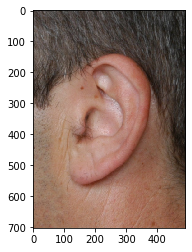

Datensatz: AMI

Anzahl der Bilder insgesamt:	 140
Anzahl der Trainingsdatensätze:	 100
Anzahl der Testdatensätze:	 40

Kategorien: ['000', '001', '002', '003', '004', '005', '007', '008', '009', '010', '011', '012', '013', '014', '018', '019', '020', '026', '027', '028']
20


In [11]:
## Show first picture of the choosen Dataset
Show_Dataset_Picture(DATADIR, CATEGORIES)

print(f'Datensatz: {Database}')
print(f'\nAnzahl der Bilder insgesamt:\t {len(dataset_train)+len(dataset_test)}')
print(f"Anzahl der Trainingsdatensätze:\t {len(dataset_train)}")
print(f"Anzahl der Testdatensätze:\t {len(dataset_test)}")
print(f'\nKategorien: {CATEGORIES}')
print(f'{len(CATEGORIES)}')


## Train- und Testloader festlegen

In [12]:
## Create Train-DataLoader
train_loader = DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)

## Create Test-DataLoader
test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=True)

## Netzwerk festlegen

Legt Netzwerk fest und zeigt die Übersicht der Netzwerk-Struktur

In [13]:
## Get choosen Network and Network-Name
network, network_name = Network_Choice(network_string)
print(network_name)

## Show Network-Archticture with all Layers and Number of Parameters
torchsummary.summary(network, (3, 224, 224), device=DEVICE.type)

VGG11
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1

## Festlegung des eindeutigen Stempels

Eindeutiger Stempel mit Uhrzeit, um CSV-, TXT- und Log-Files wiederzuerkennen

In [14]:
## Use actual Time for individual Stamp ##
current_time = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
print(current_time)

## Unique Stamp for the identification of networks, graphs, train- and Testdata
stamp = current_time + '_' + Database + '_' + network_name

2021_02_27-21_22_49


## Festlegung 'writer' für Tensorboard

In [15]:
writer = SummaryWriter('runs/' + current_time + '_' + Database + '_' + network_name)

## Festlegung von Optimizer und Loss-Function

In [16]:
## Choose SGD (Stochastic Gradient Descent) as optimizer
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
## Choose CrossEntropyLoss as Loss
criterion = nn.CrossEntropyLoss()

## Anzeige von 4 Ohren des gewählten Datensatzes mit jeweiligem Label

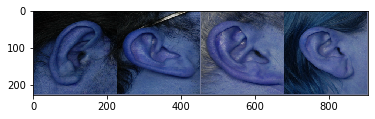

  014   009   011   004


In [17]:
## Get random images from Trainloader
dataiter = iter(train_loader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))
## print labels
print(' '.join('%5s' % CATEGORIES[labels[j]] for j in range(4)))

## Durchführung des Trainings

In [18]:
## Number of Epochs for training
epoch_range = 50

##Start Trainingtime
print("Start Training um: ", time.strftime("%H:%M:%S"))
start_time = time.time()

## Variables for Training
write_loss_epoch = ''
running_correct = 0
cancel_train = 0
predicted_roc = []

## Train Network
network.train()
for epoch in range(epoch_range):  # loop over the dataset multiple times
    
    ## Reset for every epoch
    running_loss = 0.0
    running_correct = 0
    print(f'\nEpoch {epoch+1}:')
    
    for i, data in enumerate(train_loader):
        ## Get the inputs and labels from data; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        ## Zero the parameter gradients
        optimizer.zero_grad()

        ## Calculate outputs
        network.to(DEVICE)
        outputs = network(inputs)
        
        ## Calculate loss,  Backpropagation and Optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        ## Calulate running loss
        running_loss += loss.item()
        
        ## Get predicted value
        _, predicted = torch.max(outputs.data, 1)
        
        running_correct += (predicted == labels).sum().item()
        mini_batches = round(len(train_loader)/10)
        
        if i % mini_batches == (mini_batches-1):
            print(f'[{epoch + 1}, {i + 1}]: loss: {(running_loss/mini_batches):0.3f}, \t Running_Correct: {(running_correct/mini_batches):0.3f}')#, \n\t\t Top1-Acc: {top_1.avg}, \n\t\t Top5-Acc: {top_5.avg}')
           
            ## Collect losses in Array
            write_loss_epoch += '['+ str(epoch+1)+ ', ' + str(i+1) + '] \t loss: ' + str(running_loss/mini_batches) + '\n'
            
            
            ## Write Training Loss and Training Accuracy log the running loss
            writer.add_scalar('training loss', running_loss / (mini_batches), epoch * len(train_loader) + i)
            writer.add_scalar('accuracy', (running_correct / mini_batches/4), epoch * len(train_loader) + i)
    
            ## Reset
            running_loss = 0.0
            running_correct = 0


## Finished Training: Calculate Training Time
print("Ende  Training um: ",time.strftime("%H:%M:%S"))
stop_time = time.time()
time_dif, time_format = secs_to_HMS(stop_time-start_time)
print("Dauer Training: ", time_dif, " ", time_format, " \n")

## Acoustic Sound to call attention for finished Training
WaitTime_Finished()

Start Training um:  21:22:52

Epoch 1:
[1, 2]: loss: 9.865, 	 Running_Correct: 0.000
[1, 4]: loss: 7.968, 	 Running_Correct: 0.000
[1, 6]: loss: 5.690, 	 Running_Correct: 0.000
[1, 8]: loss: 5.712, 	 Running_Correct: 0.000
[1, 10]: loss: 5.761, 	 Running_Correct: 0.000
[1, 12]: loss: 4.737, 	 Running_Correct: 0.000
[1, 14]: loss: 3.476, 	 Running_Correct: 0.500
[1, 16]: loss: 5.120, 	 Running_Correct: 0.000
[1, 18]: loss: 5.714, 	 Running_Correct: 0.500
[1, 20]: loss: 4.876, 	 Running_Correct: 0.000
[1, 22]: loss: 3.751, 	 Running_Correct: 0.000
[1, 24]: loss: 4.292, 	 Running_Correct: 1.500

Epoch 2:
[2, 2]: loss: 4.078, 	 Running_Correct: 0.500
[2, 4]: loss: 2.458, 	 Running_Correct: 1.500
[2, 6]: loss: 2.992, 	 Running_Correct: 1.500
[2, 8]: loss: 2.615, 	 Running_Correct: 0.500
[2, 10]: loss: 3.510, 	 Running_Correct: 1.500
[2, 12]: loss: 4.087, 	 Running_Correct: 0.000
[2, 14]: loss: 2.451, 	 Running_Correct: 1.500
[2, 16]: loss: 3.023, 	 Running_Correct: 0.500
[2, 18]: loss: 2.05

## Trainiertes Netzwerk speichern

In [19]:
## Path for saving trained Network
PATH = './Netzwerke/'+ current_time + '_' + Database + '_' + network_name + '_Train' + '.pth'

## Save trained Network
torch.save({
            'epoch_range': epoch_range,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'running_loss': running_loss,
            }, PATH)

In [19]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images)

# write to tensorboard
writer.add_image((current_time + '_' + Database + '_' + network_name), img_grid)
writer.add_graph(network.cpu(), images)
writer.close()

## Durchführung Testen

In [20]:
## Define global Varibales
correct = 0
total = 0
running_loss_test = 0
class_correct = list(0. for i in range(len(CATEGORIES)))
class_total = list(0. for i in range(len(CATEGORIES)))
acc_single_categorie = ''
class_probs = []
class_preds = []
pred_all = torch.tensor([], dtype=int)
labels_all = torch.tensor([], dtype=int)
top_1 = AvgrageMeter()
top_5 = AvgrageMeter()
precision_sum = 0
recall_sum = 0
f1_sum = 0
top1_sum = 0
top5_sum = 0
it = 0
len_classes = len(CATEGORIES)

## Test Network
network.eval()
with torch.no_grad():
    print(f'Dataset: {Database}, \tNetzwerk: {network_name}')
    
    for i, data in enumerate(test_loader, 0):
        
        it += 1
        ## Load images from Test-Loader and hand over to DEVICE
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        ## Calculate the predicted outputs
        network.to(DEVICE)
        outputs = network(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in outputs]
        
        ## Calculate the Test-Loss
        loss = criterion(outputs, labels)
        running_loss_test += loss.item()
        
        ## Get predicted values
        _, predicted = torch.max(outputs.data, 1)
        
        ## Calculate the Total and Correct Test-Results
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        
        
        ## Create a Tensor-Array with all Predicted-Values
        pred_all = torch.cat([pred_all, predicted.cpu()])
        ## Create a Tensor with all Label-Values
        labels_all = torch.cat([labels_all, labels.cpu()])
        
        ## Create a Tensor-Array with all Predicted-Values for Tensorboard
        class_probs.append(class_probs_batch)
        class_preds.append(predicted) 
        test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
        test_preds = torch.cat(class_preds)
        
        
        ## Calculate and update the Top-1 and Top-5 Accuracy
        prec1, prec5 = torch_utils.accuracy(output=outputs, target=labels, top_k=(1, 5))
        top_1.update(prec1.data, inputs.size(0))
        top_5.update(prec5.data, inputs.size(0))

        
        ## Calculate F1-Score without OneHot 
        f1_score_t = F1(num_classes=len_classes, average='micro')
        f1_score = f1_score_t(predicted.cpu(), labels.cpu())
        f1_sum += f1_score 
        
        
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        
        ## Write Test-Accuracy and Test-Loss to Tensorboard
        writer.add_scalar('Test Accuracy',
                          100 * correct / total,
                          len(test_loader)+i)
        writer.add_scalar('Test Loss',
                           running_loss_test,
                           len(test_loader) + i)

        
        
        
## Calculate the Test-Acuracy with all Predicted-Values and Labels
accuracy = Accuracy()
acc_all_b = accuracy(pred_all, labels_all)
acc_all = acc_all_b * 100

## Calculate the F1-Score
## with PyTorch-Lightning
f1_score_t = F1(num_classes=len_classes, average='micro')
f1_score = f1_score_t(pred_all.cpu(), labels_all.cpu())
f1_score_all = 100 * f1_score


## OneHot Function for all Predicted-Values
preds_onehot = (F.one_hot(pred_all)).float()


## Calculate the Mean-Value of the Precision
## with PyTorch-Lightning
average_precision = AveragePrecision(num_classes=len_classes)
prec_avg = average_precision(preds_onehot, labels_all)
prec_mean_t = torch.mean(torch.stack(prec_avg))
prec_mean = 100 * prec_mean_t

## Calculate the AUC-Value
## with PyTorch-Lightning
auroc = multiclass_auroc(pred=preds_onehot, target=labels_all, num_classes=len_classes)
auroc_1 = 100 * auroc


# Calculate finale Values without OneHot
acc = 100 * correct / total
f1_f = 100 * f1_sum /it
top_1_f = float((top_1.avg).cpu().numpy())
top_5_f = float((top_5.avg).cpu().numpy())
acc = 100 * correct / total


print(f"\nAccuracy    of the network on the {len(dataset_test)} test images: {acc:.2f} %")
print(f'Acc_PyLig     of the network on the {len(dataset_test)} test images: {acc_all:.2f} %')
print(f"F1            of the network on the {len(dataset_test)} test images: {f1_f:.2f} ")
print(f'F1_PyLig      of the network on the {len(dataset_test)} test images: {f1_score_all}')
print(f'AUC_PyLig:    of the network on the {len(dataset_test)} test images: {auroc_1:.2f}')
print(f"Top1          of the network on the {len(dataset_test)} test images: {top_1_f:.2f} %")
print(f"Top5          of the network on the {len(dataset_test)} test images: {top_5_f:.2f} %")


## Overview: Accaurcy of every Categorie
print(f"\nOverview: Accuracy of each class:")
for i in range(len(CATEGORIES)):
    if(class_total[i]==0):
        class_total[i] = 0.1
    print('Accuracy of %5s : %2d %%' % (CATEGORIES[i], 100 * class_correct[i] / class_total[i]))
    acc_single_categorie = 'Accuracy of\t'+ CATEGORIES[i] + ':\t\t' + str(100 * class_correct[i] / class_total[i]) + '%\n'
    Write_Each_Categorie_Acc_To_Editor(Database, network_name, acc_single_categorie)
    
WaitTime_Finished()

Dataset: AMI, 	Netzwerk: VGG11


C:\Users\wurhofer\anaconda3\envs\Test\lib\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



Accuracy    of the network on the 40 test images: 92.50 %
Acc_PyLig     of the network on the 40 test images: 92.50 %
F1            of the network on the 40 test images: 92.50 
F1_PyLig      of the network on the 40 test images: 92.5
AUC_PyLig:    of the network on the 40 test images: 96.05
Top1          of the network on the 40 test images: 92.50 %
Top5          of the network on the 40 test images: 100.00 %

Overview: Accuracy of each class:
Accuracy of   000 :  0 %
Accuracy of   001 : 100 %
Accuracy of   002 : 100 %
Accuracy of   003 : 100 %
Accuracy of   004 : 100 %
Accuracy of   005 : 100 %
Accuracy of   007 : 100 %
Accuracy of   008 : 100 %
Accuracy of   009 : 100 %
Accuracy of   010 : 100 %
Accuracy of   011 : 100 %
Accuracy of   012 : 100 %
Accuracy of   013 : 100 %
Accuracy of   014 :  0 %
Accuracy of   018 : 100 %
Accuracy of   019 : 50 %
Accuracy of   020 : 50 %
Accuracy of   026 : 100 %
Accuracy of   027 : 100 %
Accuracy of   028 : 100 %


## Funktion und Ausführung um weitere Daten und Parameter in Log-File zu schreiben

In [26]:
## Write to Log-Files (TXT-File) ##
def Write_Training_Loss_To_Editor(database, net, train_num, test_num, accuracy, loss_epoch):
    logfile_path = './Log_Files/' + database + '/' + str(current_time) + '_' + net   + '.txt'
    #logfile_path = './Log_Files/Test.txt'
    print(logfile_path)

    datei = open(logfile_path, 'a')
    datei.write("Datensatz: ")
    datei.write(Database + "\n\n")
    datei.write("Netzwerk: " + net + "\n\n")
    datei.write("Anzahl der Trainingsdatensaetze: \t" + str(train_num) + "\n")
    datei.write("Anzahl der Testdatensaetze: \t\t" + str(test_num) + "\n\n")
    datei.write("Accuracy des " + net + "-Netzwerks " + "bei " + str(test_num) + " Testbilder:  " + str(accuracy) + "%\n\n")
    datei.write(loss_epoch)
    datei.close()

Write_Training_Loss_To_Editor(Database, network_name, len(dataset_train), len(dataset_test), acc, write_loss_epoch)

./Log_Files/AMI/2021_02_27-17_31_53_AlexNet.txt


## Funktion um PR-Kurve für jede Kategorie in Tensorboard zu übertragen

Hinweis: Diese Funktion kann ausgeführt werden, wird aber in der Arbeit nicht weiter analysiert

In [28]:
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(CATEGORIES[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(CATEGORIES)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

## Schreiben der Daten ins Logbuch

Schreibt alle gesammelten Daten und berechneten Parameter in ein CSV-File

* **Write_Data_To_CSV():** 
    Schreibt alle Accuracy-Werte aller genutzten Netzwerke in ein CSV-File
* **Write_Data_To_CSV_expand():**
    Schreibt alle berechnten Parameter (Top1-/Top5-Accuracy, AUC, F1-Score) in ein CSV-File

In [44]:
## Function to write Data to CSV-File
def Write_Data_To_CSV(database, net, train_num, test_num, batchSize_Train, batchSize_Test, learning_rate, momentum, epoch, running_loss, train_time, time_format, accuracy, stamp):
    CSV = pd.read_csv("CSV_Files/Logbuch_CSV_corr.csv", sep=';')
    CSV_df = pd.DataFrame(CSV)

    Names = [{   
                "Datensatz":database,
                "Netzwerk":net,
                "Anzahl Trainingsbilder": train_num,
                "Anzahl Testbilder": test_num,
                "Batch_Size Training": batchSize_Train,
                "Batch_Size Test": batchSize_Test,
                "Learning Rate": learning_rate,
                "Momentum": momentum,
                "Epochen": epoch+1, 
                "Running Loss": running_loss, 
                "Dauer Training":train_time, 
                "Zeitformat":time_format,
                "Accuracy": accuracy, 
                "Stempel": stamp
             }]
    Names_df = pd.DataFrame(Names)
    df_neu = CSV_df.append(Names_df, ignore_index=True)
    df_neu.to_csv("CSV_Files/Logbuch_CSV.csv", sep=';', index=False, header=True)
    return pd.read_csv("CSV_Files/Logbuch_CSV.csv", sep=';')

In [45]:
def Write_Data_To_CSV_expand(database, net, train_num, test_num, batchSize_Train, batchSize_Test, learning_rate, momentum, epoch, running_loss, train_time, time_format, accuracy, Acc_all, Top_1_f, Top_5_f, AUC, F1_f, F1_score_all, stamp):
    CSV = pd.read_csv("CSV_Files/Logbuch_CSV_erweitert.csv", sep=';')
    CSV_df = pd.DataFrame(CSV)

    Names = [{   
                "Datensatz":database,
                "Netzwerk":net,
                "Anzahl Trainingsbilder": train_num,
                "Anzahl Testbilder": test_num,
                "Batch_Size Training": batchSize_Train,
                "Batch_Size Test": batchSize_Test,
                "Learning Rate": learning_rate,
                "Momentum": momentum,
                "Epochen": epoch+1, 
                "Running Loss": running_loss, 
                "Dauer Training":train_time, 
                "Zeitformat":time_format,
                "Accuracy": accuracy, 
                "Accuracy_PyLig": Acc_all.numpy(),
                "Top1": Top_1_f,
                "Top5": Top_5_f,
                "AUC": AUC.numpy(),
                "F1_my": F1_f.numpy(),
                "F1_PyLig": F1_score_all.numpy(),
                "Stempel": stamp
             }]
    Names_df = pd.DataFrame(Names)
    df_neu = CSV_df.append(Names_df, ignore_index=True)
    df_neu.to_csv("CSV_Files/Logbuch_CSV_erweitert.csv", sep=';', index=False, header=True)
    return pd.read_csv("CSV_Files/Logbuch_CSV_erweitert.csv", sep=';')

In [40]:
Write_Data_To_CSV_expand(Database, network_name, len(dataset_train), len(dataset_test), batch_size_train, batch_size_test, learning_rate, momentum, epoch, running_loss, time_dif, time_format, acc, acc_all, top_1_f, top_5_f, auroc_1, f1_f, f1_score_all, stamp)

Datensatz            Netzwerk  Anzahl Trainingsbilder  Anzahl Testbilder  \
0         Neu                 NaN                     NaN                NaN   
1          CP    Resnext101-32x8d                    68.0               34.0   
2         AMI    Resnext101-32x8d                   500.0              200.0   
3         AWE    Resnext101-32x8d                   800.0              200.0   
4        UERC    Resnext101-32x8d                  2192.0              548.0   
5        CP_e  Resnext101-32x8d_e                   340.0               68.0   
6       AMI_e  Resnext101-32x8d_e                  2400.0              400.0   
7       AWE_e  Resnext101-32x8d_e                  3200.0              800.0   
8      UERC_e  Resnext101-32x8d_e                  8768.0             2192.0   
9   EarVN_1_0    Resnext101-32x8d                 22681.0             5731.0   
10        AMI             AlexNet                   100.0               40.0   

    Batch_Size Training  Batch_Size Test  Learning Rate  Momentum  Epochen  \
0                   NaN              NaN            NaN       NaN      NaN   
1                   4.0              4.0          0.001       0.8     50.0   
2                   4.0              4.0          0.001       0.8     50.0   
3                   4.0              4.0          0.001       0.8     50.0   
4                   4.0              4.0          0.001       0.8     50.0   
5                   4.0              4.0          0.001       0.8     50.0   
6                   4.0              4.0          0.001       0.8     50.0   
7                   4.0              4.0          0.001       0.8     50.0   
8                   4.0              4.0          0.001       0.8     50.0   
9                   4.0              4.0          0.001       0.8     50.0   
10                  4.0              4.0          0.001       0.8     50.0   

              Running Loss Dauer Training  Zeitformat               Accuracy  \
0                      NaN            NaN         NaN                    NaN   
1     0.005421876907348633          02:51     [MM:SS]                  97.06   
2     0.026825428009033203          21:03     [MM:SS]                   96.0   
3                      0.0       33:36:00     [MM:SS]                   51.5   
4       0.6218500137329102       02:32:02  [HH:MM:SS]                  30.29   
5     0.009591817855834961          14:22     [MM:SS]                  100.0   
6                      0.0       02:40:59  [HH:MM:SS]                  100.0   
7                      0.0       03:14:34  [HH:MM:SS]                 98.375   
8     0.004006385803222656       07:07:53  [HH:MM:SS]  9.630.474.452.554.740   
9   29.751.343.727.111.800       17:26:41  [HH:MM:SS]                  92.23   
10  0.00015020370483398438          00:22     [MM:SS]                   95.0   

   Accuracy_PyLig                   Top1                   Top5        AUC  \
0             NaN                    NaN                    NaN        NaN   
1           97.06                  97.22                  100.0      98.44   
2            96.0                   96.0                   99.0      97.98   
3            51.5                   51.5                   73.0      75.51   
4           30.29                  30.29                  49.63      65.02   
5           100.0                  100.0                  100.0      100.0   
6           100.0                  100.0                  100.0      100.0   
7          98.375                 98.375                   99.5  9.917.928   
8       9.630.474  9.630.474.090.576.170  9.945.255.279.541.010  9.814.559   
9      92.235.214  9.223.656.463.623.040  9.738.311.004.638.670  9.600.976   
10           95.0                   95.0                  100.0  97.368416   

         F1_my    F1_PyLig                                         Stempel  
0          NaN         NaN                                             NaN  
1        97.22       97.06         2021_02_03-18_10_22

In [46]:
Write_Data_To_CSV(Database, network_name, len(dataset_train), len(dataset_test), batch_size_train, batch_size_test, learning_rate, momentum, epoch, running_loss, time_dif, time_format, acc, stamp)

Datensatz                Netzwerk  Anzahl Trainingsbilder  \
0            AWE                   VGG11                     800   
1             CP                   VGG11                      68   
2            AMI                   VGG11                     500   
3      EarVN_1_0                   VGG11                   22681   
4    EarVN_1_0_e                 VGG11_e                   22681   
..           ...                     ...                     ...   
151     WPUT_e_w           GoogLeNet_e_w                    9076   
152     WPUT_e_w  Shufflenet-v2-x0_5_e_w                    9076   
153     WPUT_e_w    Resnext101-32x8d_e_w                    9076   
154       UERC_w      Resnext101-32x8d_w                    2192   
155          AMI                 AlexNet                     100   

     Anzahl Testbilder  Batch_Size Training  Batch_Size Test  Learning Rate  \
0                  200                    4                4          0.001   
1                   34                    4                4          0.001   
2                  200                    4                4          0.001   
3                 5731                    4                4          0.001   
4                 5731                    4                4          0.001   
..                 ...                  ...              ...            ...   
151               2904                    4                4          0.001   
152               2904                    4                4          0.001   
153               2904                    4                4          0.001   
154                548                    4                4          0.001   
155                 40                    4                4          0.001   

     Momentum  Epochen            Running Loss Dauer Training  Zeitformat  \
0         0.8       25             0.018202782          04:11     [MM:SS]   
1         0.8       49             0.001134396          00:42     [MM:SS]   
2         0.8       49             0.002470016          05:06     [MM:SS]   
3         0.8       49                       0       04:50:23  [HH:MM:SS]   
4         0.8       49                       0       04:50:23  [HH:MM:SS]   
..        ...      ...                     ...            ...         ...   
151       0.8       50   4.961.103.916.168.210       03:17:00  [HH:MM:SS]   
152       0.8       50  43.149.518.966.674.800       03:09:59  [HH:MM:SS]   
153       0.8       50             0.841792107       07:52:04  [HH:MM:SS]   
154       0.8       50             0.597034216       02:36:52  [HH:MM:SS]   
155       0.8       50  0.00015020370483398438          00:22     [MM:SS]   

     Accuracy                                      Stempel  
0       24.13                2020_10_13-13_47_08_AWE_VGG11  
1       94.12                 2020_10_13-13_47_08_CP_VGG11  
2       78.00                2020_10_13-13_47_08_AMI_VGG11  
3       68.14          2020_10_13-13_47_08_EarVN_1_0_VGG11  
4       68.14          2020_10_13-13_47_08_EarVN_1_0_VGG11  
..        ...                                          ...  
151     99.44           2020_11_01-11_07_43_WPUT_GoogLeNet  
152     99.35  2020_11_01-13_56_51_WPUT_Shufflenet-v2-x0_5  
153    100.00    2020_11_01-16_10_09_WPUT_Resnext101-32x8d  
154     44.13    2020_10_23-10_11_30_UERC_Resnext101-32x8d  
155     95.00              2021_02_27-17_31_53_AMI_AlexNet  

[156 rows x 14 columns]

## PR-Kurve mit Tensorboard

Generiert für alle Kategorien eine PR-Kurve in Tensorboard. Diese Funktion wird schlußendlich nicht zur Bewertung der Datensätze und Netzwerke verwendet.

In [33]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run

class_probs = []
class_preds = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        network.to(DEVICE)
        network.cpu()
        output = network(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(CATEGORIES[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(CATEGORIES)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)